In [ ]:
%config InlineBackend.figure_formats = ['svg']

## Symulacje numeryczne interferencji dla przybliżenia płaskiej wody
### Patryk Kościelniak
### Semestr 2025/2026

### 1. Opis problemu
Symulujemy układ w którym rozważamy dwa źródła fal kulistych. Źródła leżą na wspólnej prostej prostej, prosta ta wyznacza kierunek osi Y. Kierunek osi X jest kierunkiem prostopadłym do osi Y. Celem jest porównanie modelu numerycznego z wynikiem teoretycznym. Dla płaszczyzny odalonej od środka układu i równoległe do osi X wartość naterzenia od dwóch źródeło wielkości $a$ (dla źródeł jednorodnych)  odalonych od siebie o odległość $d$ (odległość jest mierzona miedzy środkami źródeł) wynosi

$$ I(x) = I_0 \left(\frac{\sin(\alpha)}{\alpha}\right)^2\cos^2\left(\phi\right) $$
$$ \phi = \frac{1}{2} d \ k \frac{x}{\sqrt{x^2 + y_0^2}} \quad \quad \quad \alpha = \frac{1}{2} a \ k \frac{x}{\sqrt{x^2 + y_0^2}}$$

W przybliżeniu SWE relacja dyspersji wynosi

$$k = \frac{\omega}{\sqrt{hg}}$$

### 2. Implementacja całkowania równania SWE
Krótkie uwagi, źródła fali kulistej są zaimplementowane jako siatki [5 x 5]. Wartość wyhylenia od powieszcni wewnątrz danego punktu siatki dana jest przy pomocy następującego równania

$$ \Delta h_{ij} = h_0 * w_{ij} * \cos(\widetilde{\omega} * n_t) $$

gdzie: $w_{ij}$ to waga $ij$ elementu, $h_0$ to amplituda wychylenia, $\widetilde{\omega}$ to bezwymiarowa czestość kołowa, $n_t$ iliczba iteracji. Do obliczeń odległość między źródłąmi $d$ wynosi 40 oczek siatki. W algorytime całkującym użyto warunku brzegowego ekstrapolującego. Reszta implementacji to kod z zajęć.

In [1]:
import numpy as np
from matplotlib import pyplot, rcParams
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

In [ ]:
rcParams['figure.dpi'] = 96

In [2]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, omega_per_iter: float, amplitude: float, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True, third_order_terms=True,)
        index_x, index_y, solver_grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=solver_grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Extrapolated()] * len(solver_grid),
            #'boundary_conditions': (boundary_conditions.Extrapolated(), boundary_conditions.Constant(0)),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(solver_grid), **kwargs),
            "vh": ScalarField(np.zeros(solver_grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((solver_grid[index_x] + 1, solver_grid[index_y])),
                np.zeros((solver_grid[index_x], solver_grid[index_y] + 1))
            ), **kwargs
        )
        self.amp = amplitude
        self.omega_per_iter = omega_per_iter
        self.h_0 = np.max(h_initial)
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'], axis=axis)

    def _apply_half_sources(self,*, key, nt):
        """ applies half of the source term in the given direction """
        grid_sources = self[key].shape

        iy = 20
        y_slice = slice(iy-2, iy+3)
        x_half = grid_sources[0] // 2
        half_width = 20
        #ix_1 = int(grid_sources[0] * 0.35)
        ix_1 = x_half - half_width
        x1_slice = slice(ix_1-2, ix_1+3)
        ix_2 = x_half + half_width
        #ix_2 = int(grid_sources[0] * 0.65)
        x2_slice = slice(ix_2-2, ix_2+3)

        kernel = np.array([
            [0.01, 0.02, 0.03, 0.02, 0.01],
            [0.02, 0.06, 0.08, 0.06, 0.02],
            [0.03, 0.08, 0.10, 0.08, 0.03],
            [0.02, 0.06, 0.08, 0.06, 0.02],
            [0.01, 0.02, 0.03, 0.02, 0.01],
        ])
        kernel = kernel/np.sum(kernel)

        phase = np.cos(self.omega_per_iter * nt)

        self[key][x1_slice, y_slice] += .5 * self.amp * self.h_0 *kernel * phase
        self[key][x2_slice, y_slice] += .5 * self.amp * self.h_0 * kernel * phase

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all_indexes = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all_indexes),
            (all_indexes, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all_indexes),
            (all_indexes, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        solver_output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1): 
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self._apply_half_sources(key='h',nt=it-1)
                self.solvers["h"].advance(n_steps=1)
                self._apply_half_sources(key='h', nt=it-1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    solver_output[key].append(self[key].copy())
        return solver_output

### 3. Parametry obliczeń oraz wynki obliczeń
#### 3.1 Parametry pierwszej siatki
Rozmiar siatki $n_x = 150, n_y = 75$. <br>
Liczba kroków czasowych $n_t = 175$. <br>
Stosunek kroku czasowego do kroku przestrzengo $\frac{\Delta t}{\Delta x} = \frac{1}{4}$. <br>
Umowna wielkość kroku przestrzengo $\Delta x$ = 1. <br>
Warunek początkowy dla ukłądu $h(x,y, t = 0) = 1$. <br>
Wartość stałej wymuszenia $h_0 = 20 \% \ h(x,y,t = 0)$. <br>
Cześtość kołowa wymuszenia bezwymiarowa $\widetilde{\omega} = 1.0 \Delta t $. <br>
Wartość przyśpieszenia siły zewnętrzenej w kierunku z $g = 10$. <br>

In [3]:
grid = (300, 150)

h_0 = np.ones(grid, dtype=float)
dt = 0.25
omega = 1.0
omega_it = omega * dt
amp = 0.2
grav = 10

solver = ShallowWaterEquationsIntegrator(h_initial=h_0, omega_per_iter=omega_it, amplitude = amp)
output = solver(nt=175, g=grav, dt_over_dxy=(dt, dt), outfreq=1)

In [4]:
def rms_in_xplane(psi_arg: np.ndarray, x_plane_index, time_range: slice):
    """psi has to be ndarray that contains time evolution over grid"""
    psi_slice_arg = psi_arg[time_range, : , :]
    psi_slice_arg = psi_slice_arg[:, :, x_plane_index]
    return np.mean(np.square(psi_slice_arg), axis=0)

#### 3.2 Wynki obliczen dla siatki $n_x = 300, n_y = 150$
Na poniszych rysunkach znajdują się wynki obliczeń. Na pierwszym rysunku przedstawiony jest natężenie otrzymane wynkiu symulacji oraz wynki analityczny. Natężenie fali wyliczono licząc średnią kwadratową wychylenia $h$ w każdym punkcie płaszczyzny położonej $y_0$ od środka ukłądu. Ze względu na stabilizację układu oraz dotracie wali do płaszczyzny średnia jest liczona tylko dla wybranego odcinka symulacji. Ze względu na niejednorodność źródła fali założono promień effektwyny źródła $a = 4$.

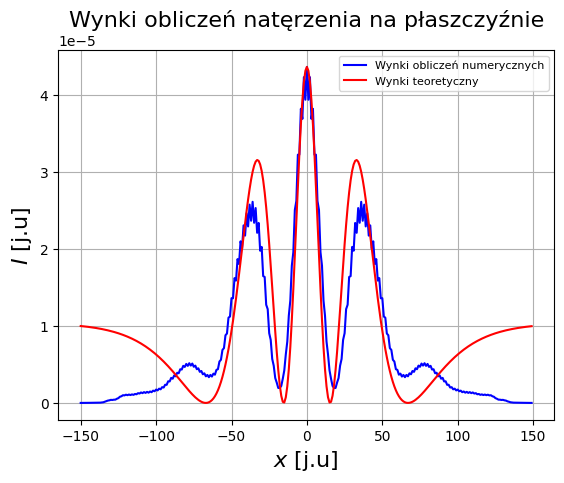

In [5]:
psi_out = output['h'] - np.ones(grid)
x_pos, y_pos = np.indices(psi_out[0].shape)
offset_ypos = 20
offset_xpos = psi_out.shape[1]//2
x_pos = x_pos - offset_xpos
y_pos = y_pos - offset_ypos

k_wave = omega / np.sqrt(np.max(h_0) * grav)
d = 40
a = 4
y0 = 60
x_plane= x_pos[:,0]
phase_interference = np.cos(0.5 * d * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
phase_diff_envelope = np.sinc(0.5 * a * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
psi_rms = rms_in_xplane(psi_arg=psi_out, x_plane_index=y0+offset_ypos, time_range=slice(80,None))
I_0 = np.max(psi_rms)
psi_theor = I_0 * np.square(phase_diff_envelope * phase_interference)

pyplot.plot(x_plane, psi_rms, color='blue')
pyplot.plot(x_plane, psi_theor, color='red')
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$I$ [j.u]", fontsize=16)
pyplot.legend(["Wynki obliczeń numerycznych", "Wynki teoretyczny"], fontsize=8)
pyplot.title("Wynki obliczeń natęrzenia na płaszczyźnie", fontsize=16)
pyplot.grid()
pyplot.show()

Na rysunku przedstawie jest wynki dla płaszczyzny $y_0 = 60$, dla okresu całkowania od 80 kroku do końca symulacji. Jak widać na rysunku wynki zgadzają się z ogromną dokładnośćią w dla środka układu z wynkiem teoretyczynm i rozbiegają znacząco na krańcach pudła. Widać również przestunięcie w wynkiu numerycznego bliżej krańców pudła. Rozbierzność na krańcach pudła można wytłumaczyć tym, że fala nie doszła do granic pudła oraz tym, że wynkiu dyfuzji numerycznej wartość sygnału dalej od środka pudla spada znacząco. Przesunięcie pików ku brzegom pudłą nie wiązał bym z dyfuzją numeryczną lecz z niedokładnością założęń co do wielkości $a$ oraz $k$ <br>
Na następnym rysunku przedstawiono wartość kwadratu wychlenia $h$ od powieszchni w ostatnim kroku symulacji.

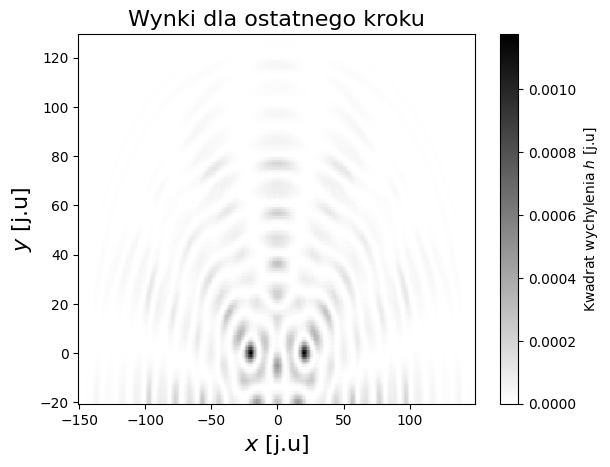

In [6]:
pyplot.pcolormesh(x_pos, y_pos, np.square(psi_out[-1]), cmap="binary")
pyplot.colorbar(label="Kwadrat wychylenia $h$ [j.u]")
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$y$ [j.u]", fontsize=16)
pyplot.title("Wynki dla ostatnego kroku", fontsize=16)
pyplot.show()

Na rysunku widać kwadrat wychylenia $h$ od powieszchni. Na rysunku widać, bardzo jasno iterferencję jak również dyfuzję numeryczną.

#### 3.3 Analiza wyników dla zmniejszenia rozdzielczości czasowej.
Stosunek kroku czasowego $\frac{\Delta t}{\Delta x} = \frac{1}{8}$. <br>
Liczba kroków czasowych $n_t$ = 350. <br>
Wynki są ewidentnie niestabline wokół źródeł. Najprawdopodobniej poprawienie stabilności wymagało by wprowadzenia jeszcze większego jądra do źródeł by poprawić stabilonść wynkiów. W dotychczasowych wynkiach ewidentnie pojawiają się składowe o wyszych wektorach fallowych i wprowadzają oscylacje które są nie fizyczne. 

In [7]:
dt = 0.125
omega_it = omega * dt
output = solver(nt=350, g=grav, dt_over_dxy=(dt, dt), outfreq=1)
del solver

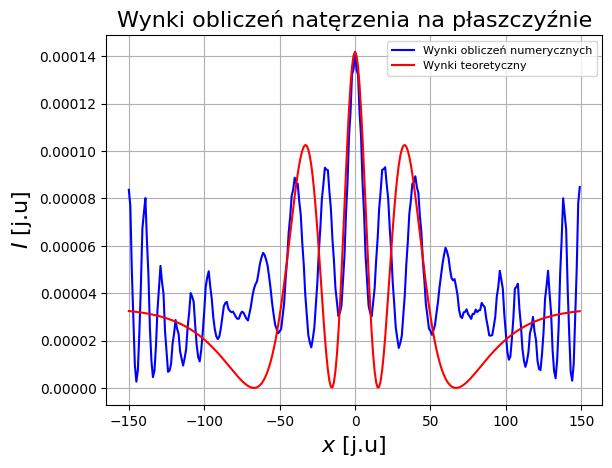

In [9]:
psi_out = output['h'] - np.ones(grid)
x_pos, y_pos = np.indices(psi_out[0].shape)
offset_ypos = 20
offset_xpos = psi_out.shape[1]//2
x_pos = x_pos - offset_xpos
y_pos = y_pos - offset_ypos

k_wave = omega / np.sqrt(np.max(h_0) * grav)
d = 40
a = 4
y0 = 60
x_plane= x_pos[:,0]
phase_interference = np.cos(0.5 * d * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
phase_diff_envelope = np.sinc(0.5 * a * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
psi_rms = rms_in_xplane(psi_arg=psi_out, x_plane_index=y0+offset_ypos, time_range=slice(80,None))
I_0 = np.max(psi_rms)
psi_theor = I_0 * np.square(phase_diff_envelope * phase_interference)

pyplot.plot(x_plane, psi_rms, color='blue')
pyplot.plot(x_plane, psi_theor, color='red')
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$I$ [j.u]", fontsize=16)
pyplot.legend(["Wynki obliczeń numerycznych", "Wynki teoretyczny"], fontsize=8)
pyplot.title("Wynki obliczeń natęrzenia na płaszczyźnie", fontsize=16)
pyplot.grid()
pyplot.show()

del output

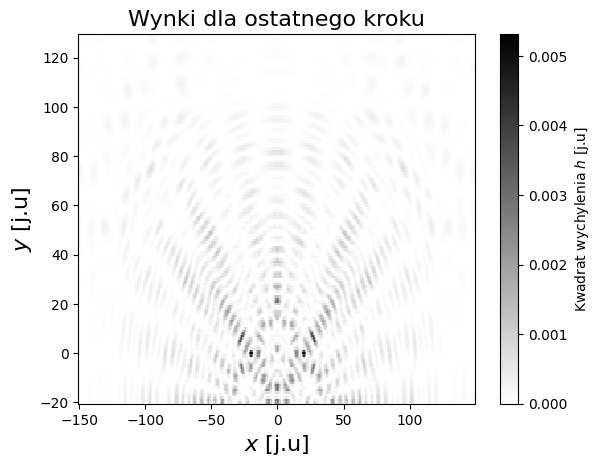

In [10]:
pyplot.pcolormesh(x_pos, y_pos, np.square(psi_out[-1]), cmap="binary")
pyplot.colorbar(label="Kwadrat wychylenia $h$ [j.u]")
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$y$ [j.u]", fontsize=16)
pyplot.title("Wynki dla ostatnego kroku", fontsize=16)
pyplot.show()

### 3.4 Analiza dla dwókrotnie mniejszej siatki.
Rozmiar siatki $n_x = 150, n_y = 75$ <br>
W wynkiach odczytywana płaszczyzna $y_0 = 50$. Jest to związane z tym że płaszczyzna $y_0=60$ jest poza pudłem obliczeniowym. <br>
Z ogólnych porównań odrazu widać pogorszenie wyników symulacji. Rozmiar siatki jest najbardziej kluczowym elementem poprawności symulacji. Ze względu na to, że implementacjia otwartego waunku brzegowego nie działa wystarczająco dokładnie. Na wynkiach przekroju widać odbitą falę oraz natomiast na rysunku przedstawiającym ostatni krok symulacji widać interferencje z falą odbitą od brzegu pudła.

In [13]:
grid = (150, 75)

h_0 = np.ones(grid, dtype=float)
dt = 0.25
omega = 1.0
omega_it = omega * dt
amp = 0.2
grav = 10

solver = ShallowWaterEquationsIntegrator(h_initial=h_0, omega_per_iter=omega_it, amplitude = amp)
output = solver(nt=150, g=grav, dt_over_dxy=(dt, dt), outfreq=1)
del solver

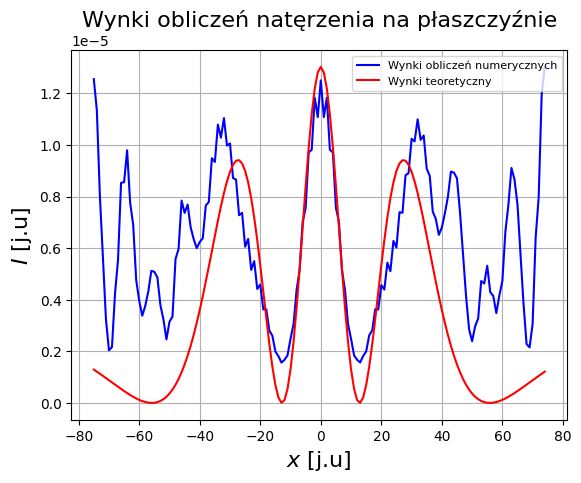

In [16]:
psi_out = output['h'] - np.ones(grid)
x_pos, y_pos = np.indices(psi_out[0].shape)
offset_ypos = 20
offset_xpos = psi_out.shape[1]//2
x_pos = x_pos - offset_xpos
y_pos = y_pos - offset_ypos

k_wave = omega / np.sqrt(np.max(h_0) * grav)
d = 40
a = 4
y0 = 50
x_plane= x_pos[:,0]
phase_interference = np.cos(0.5 * d * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
phase_diff_envelope = np.sinc(0.5 * a * k_wave * x_plane/np.sqrt(x_plane**2 + y0**2))
psi_rms = rms_in_xplane(psi_arg=psi_out, x_plane_index=y0+offset_ypos, time_range=slice(80,None))
I_0 = np.max(psi_rms)
psi_theor = I_0 * np.square(phase_diff_envelope * phase_interference)

pyplot.plot(x_plane, psi_rms, color='blue')
pyplot.plot(x_plane, psi_theor, color='red')
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$I$ [j.u]", fontsize=16)
pyplot.legend(["Wynki obliczeń numerycznych", "Wynki teoretyczny"], fontsize=8)
pyplot.title("Wynki obliczeń natęrzenia na płaszczyźnie", fontsize=16)
pyplot.grid()
pyplot.show()

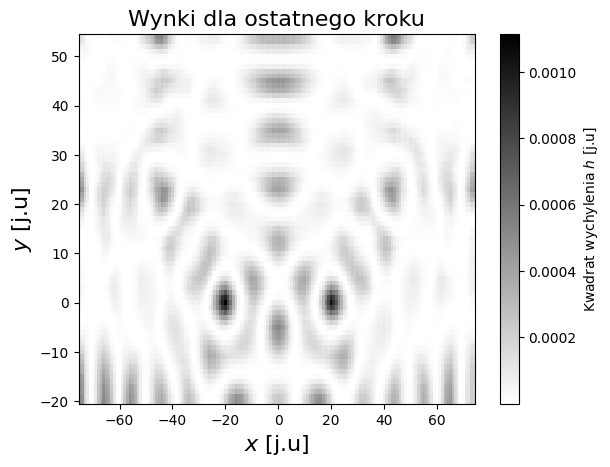

In [17]:
pyplot.pcolormesh(x_pos, y_pos, np.square(psi_out[-1]), cmap="binary")
pyplot.colorbar(label="Kwadrat wychylenia $h$ [j.u]")
pyplot.xlabel("$x$ [j.u]", fontsize=16)
pyplot.ylabel("$y$ [j.u]", fontsize=16)
pyplot.title("Wynki dla ostatnego kroku", fontsize=16)
pyplot.show()

### 4. Wnioski
Interferencja da się w niezwykle dokładny sposób modelować przy urzyciu algorytmów całkujących równania płaskiej wody. Większość obecnie występujących problemów można rozwiązać poprzez adekwatnych rozwiązań. Najważniejszym polem do poprawy najproawdopodobniej powiny być otwarte warunki brzegowe. Na moment obecny warunek brzegowy dalej odaje cześć pędu spowrotem do pódła. Nie tylko zaburza to dokładność wyniku, ale także wprowadza dodatkowe pęd do systemu co może skutkować złamaniem kryterum CFL. Wynki można było by również poprawić redukując w większym stopniu defuzję numeryczną, albo uwzględniając ją w modelowaniu teoretycznym. Ostatnim problemem są źródłą punktowe. Problemem jest ewidenta sztwyność dla jądra jedno punktowego. Zwiększanie jądra pozwala na zwalaczanie sztywności, ale to wymaga większych siatek. W szczególności modło by to być problemem dla symulacji gdzie odległość źródeł $d < \frac{a}{2}$ ponieważ źródłą by zaczeły nagodzić na siebie.